In [237]:
import pandas as pd
from matplotlib import pyplot as plt

import numpy as np
import seaborn as sns

from consts import *
import utils
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import ast
import pvgis_requests_processing


In [238]:
estimated_production_by_building = pd.read_csv(BUILDINGS_MAPPED_PATH)
roofs_data = pd.read_csv(RECALCULATED_ROOFS_PATH)

### Cleaning

#### Cleaning buildings

In [239]:
roofs_data[ETAK_ID] = roofs_data[ETAK_ID].astype(str)
estimated_production_by_building[ETAK_ID] = estimated_production_by_building[ETAK_ID].astype(str)
estimated_production_by_building["ehr_code"] = estimated_production_by_building["ehr_code"].astype(str)


In [240]:
estimated_production_by_building.head()

,etak_id,lat,lon,total_roof_area,district,annual_kwh,pv_area_m2,annual_kwh/pv_m2,Jan_kwh,Feb_kwh,...,energy_label,assembly,business,educational,industrial,institutional,mercantile,other,residential,storage
0,7106760,58.345708,26.723822,26.20,Ropka tööstuse,5242.83,20.960,250.135019,120.03,267.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,728449,58.354539,26.727600,34.22,Ropka,6839.15,27.376,249.822838,142.16,345.88,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,737756,58.357790,26.790659,204.24,Ihaste,31988.55,163.392,195.777945,398.07,1080.68,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.751773,0.0
3,710836,58.367784,26.729952,32.82,Karlova,6561.06,26.256,249.888026,136.53,331.96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,726205,58.352388,26.717920,19.45,Ropka,2701.48,15.560,173.616967,20.05,69.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [241]:
estimated_production_by_building[[TOTAL_ROOF_AREA, YEAR, 'total_area', 'floors']].describe()

,total_roof_area,year,total_area,floors
count,20729.000000,11720.000000,13677.000000,13649.000000
mean,243.135264,1977.838823,566.350274,1.830171
std,698.534630,51.934160,1814.047409,1.097875
min,2.020000,0.000000,0.000000,1.000000
25%,48.030000,1977.000000,102.800000,1.000000
50%,134.920000,1977.000000,191.900000,2.000000
75%,218.400000,1995.000000,333.700000,2.000000
max,36618.550000,2022.000000,109398.100000,23.000000


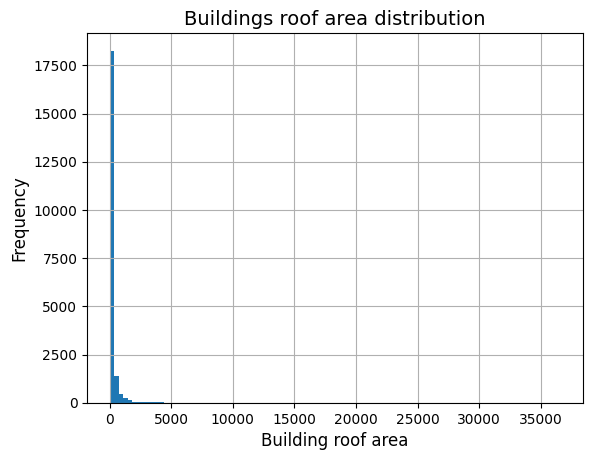

In [242]:
estimated_production_by_building[TOTAL_ROOF_AREA].hist(bins=100)
plt.xlabel("Building roof area", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Buildings roof area distribution", fontsize=14)
plt.show()

In [243]:
estimated_production_by_building[[TOTAL_ROOF_AREA, YEAR, 'total_area', 'floors']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20729 entries, 0 to 20728
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   total_roof_area  20729 non-null  float64
 1   year             11720 non-null  float64
 2   total_area       13677 non-null  float64
 3   floors           13649 non-null  float64
dtypes: float64(4)
memory usage: 647.9 KB


In [244]:
estimated_production_by_building["name"] = estimated_production_by_building["name"].apply(lambda x: x.capitalize() if pd.notna(x) else x)
estimated_production_by_building["type"] = estimated_production_by_building["type"].apply(lambda x: x.lower() if pd.notna(x) else x)


In [245]:
type_not_na = estimated_production_by_building[estimated_production_by_building["type"].notna()]
garages = type_not_na[type_not_na["type"].str.contains("garaaž", case=False)]
garages[TOTAL_ROOF_AREA].describe()


count     281.000000
mean      220.551886
std       471.397110
min         8.410000
25%        24.760000
50%        42.020000
75%       294.400000
max      6482.400000
Name: total_roof_area, dtype: float64

In [246]:
garages.shape

(281, 50)

In [247]:
garages["name"].value_counts()


name
Garaaž                 58
Garaažid               13
Grupigaraaži garaaž     6
Garaaz^                 6
Garaažiboks             3
                       ..
Garaažid(13 boksi)      1
Garaaž nr 4             1
Garaažid(24 boksi)      1
Garaaž boks nr 2        1
Abihoone                1
Name: count, Length: 180, dtype: int64

In [248]:
garages[garages["name"] == "Garaaž"][TOTAL_ROOF_AREA].describe()


count     58.000000
mean      85.954483
std      155.927680
min        8.410000
25%       24.005000
50%       27.830000
75%       56.435000
max      895.180000
Name: total_roof_area, dtype: float64

In [249]:
garages_75_percentile = garages[(garages["name"] == "Garaaž") & (garages[TOTAL_ROOF_AREA] < 57)][TOTAL_ROOF_AREA]
garages_75_percentile.describe()


count    44.000000
mean     28.194545
std      10.598395
min       8.410000
25%      22.957500
50%      25.210000
75%      29.312500
max      56.750000
Name: total_roof_area, dtype: float64

In [250]:
mean_garage_roof = round(garages_75_percentile.mean())

In [251]:
mean_garage_roof

28

In [252]:
other_buildings = type_not_na[~type_not_na["type"].str.contains("garaaž", case=False)]
other_buildings[TOTAL_ROOF_AREA].describe()

count    13394.000000
mean       329.816406
std        839.023302
min          2.610000
25%        128.115000
50%        179.580000
75%        271.532500
max      36618.550000
Name: total_roof_area, dtype: float64

In [253]:
estimated_production_by_building.shape

(20729, 50)

In [254]:
estimated_production_by_building_filtered = estimated_production_by_building[~estimated_production_by_building["type"].str.contains("garaaž", case=False, na=False)]
estimated_production_by_building_filtered.shape


(20448, 50)

In [255]:
estimated_production_by_building_filtered = estimated_production_by_building_filtered[(estimated_production_by_building_filtered[TOTAL_ROOF_AREA] > mean_garage_roof)]
estimated_production_by_building_filtered.shape

(17975, 50)

In [256]:
# estimated_production_by_building_filtered.to_csv(BUILDINGS_DIR.joinpath("buildings_without_garages.csv"), index=False)

In [257]:
estimated_production_by_building_filtered[[TOTAL_ROOF_AREA, YEAR, 'total_area']].describe()

,total_roof_area,year,total_area
count,17975.000000,11382.000000,13047.000000
mean,273.707678,1977.634511,586.605526
std,742.745613,49.197989,1852.083862
min,28.020000,0.000000,0.000000
25%,75.835000,1977.000000,111.400000
50%,151.530000,1977.000000,198.200000
75%,236.495000,1995.000000,341.750000
max,36618.550000,2022.000000,109398.100000


In [258]:
estimated_production_by_building_filtered[estimated_production_by_building_filtered['total_area'] == 0]

,etak_id,lat,lon,total_roof_area,district,annual_kwh,pv_area_m2,annual_kwh/pv_m2,Jan_kwh,Feb_kwh,...,energy_label,assembly,business,educational,industrial,institutional,mercantile,other,residential,storage
17904,711693,58.363335,26.703656,134.13,Tammelinna,19298.23,107.304,179.846324,228.01,606.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [259]:
estimated_production_by_building_filtered.loc[estimated_production_by_building_filtered[YEAR] == 0, YEAR] = np.nan

In [260]:
estimated_production_by_building_filtered = estimated_production_by_building_filtered[estimated_production_by_building_filtered['total_area'] != 0]

In [261]:
estimated_production_by_building_filtered[[TOTAL_ROOF_AREA, YEAR, 'total_area']].describe()

,total_roof_area,year,total_area
count,17974.000000,11376.000000,13046.000000
mean,273.715443,1978.502198,586.650491
std,742.765546,26.491540,1852.147727
min,28.020000,1323.000000,2.100000
25%,75.817500,1977.000000,111.400000
50%,151.545000,1977.000000,198.200000
75%,236.502500,1995.000000,341.775000
max,36618.550000,2022.000000,109398.100000


In [262]:
estimated_production_by_building_filtered = estimated_production_by_building_filtered[~(estimated_production_by_building_filtered['total_area'] < mean_garage_roof)]

In [263]:
estimated_production_by_building_filtered[[TOTAL_ROOF_AREA, YEAR, 'total_area']].describe()

,total_roof_area,year,total_area
count,17562.000000,11176.000000,12634.000000
mean,279.031605,1978.364889,605.118482
std,750.593959,26.515806,1879.235740
min,28.020000,1323.000000,28.000000
25%,81.432500,1977.000000,119.525000
50%,154.245000,1977.000000,204.200000
75%,239.695000,1995.000000,353.425000
max,36618.550000,2022.000000,109398.100000


<Axes: >

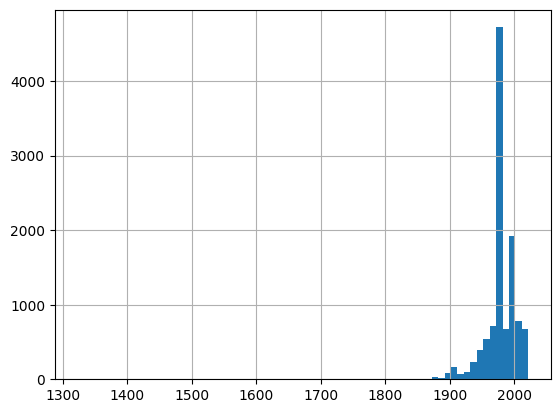

In [264]:
estimated_production_by_building_filtered[YEAR].hist(bins=70)

In [265]:
print(f"The percentage of constructions built before 1940 is {estimated_production_by_building_filtered[estimated_production_by_building_filtered[YEAR] < 1800].shape[0] / estimated_production_by_building_filtered.shape[0] * 100:.2f}%.")

The percentage of constructions built before 1940 is 0.11%.


In [266]:
estimated_production_by_building_filtered = estimated_production_by_building_filtered[~(estimated_production_by_building_filtered[YEAR] < 1800)]

In [267]:
estimated_production_by_building_filtered[[TOTAL_ROOF_AREA, YEAR, 'total_area']].describe()

,total_roof_area,year,total_area
count,17543.000000,11157.000000,12615.000000
mean,278.734642,1978.786233,604.600032
std,750.855618,24.070805,1880.462842
min,28.020000,1802.000000,28.000000
25%,81.385000,1977.000000,119.450000
50%,154.130000,1977.000000,204.100000
75%,239.205000,1995.000000,352.100000
max,36618.550000,2022.000000,109398.100000


In [268]:
etak_ids_filtered = estimated_production_by_building_filtered[ETAK_ID].unique()
etak_ids_filtered.shape

(17543,)

In [269]:
estimated_production_by_building_filtered.columns

Index(['etak_id', 'lat', 'lon', 'total_roof_area', 'district', 'annual_kwh',
       'pv_area_m2', 'annual_kwh/pv_m2', 'Jan_kwh', 'Feb_kwh', 'Mar_kwh',
       'Apr_kwh', 'May_kwh', 'Jun_kwh', 'Jul_kwh', 'Aug_kwh', 'Sep_kwh',
       'Oct_kwh', 'Nov_kwh', 'Dec_kwh', 'Jan_kwh/pv_m2', 'Feb_kwh/pv_m2',
       'Mar_kwh/pv_m2', 'Apr_kwh/pv_m2', 'May_kwh/pv_m2', 'Jun_kwh/pv_m2',
       'Jul_kwh/pv_m2', 'Aug_kwh/pv_m2', 'Sep_kwh/pv_m2', 'Oct_kwh/pv_m2',
       'Nov_kwh/pv_m2', 'Dec_kwh/pv_m2', 'ehr_code', 'address_id', 'address',
       'name', 'type', 'year', 'total_area', 'floors', 'energy_label',
       'assembly', 'business', 'educational', 'industrial', 'institutional',
       'mercantile', 'other', 'residential', 'storage'],
      dtype='object')

In [220]:
estimated_production_by_building_filtered[[
    ETAK_ID,
    LAT,
    LON, 
    TOTAL_ROOF_AREA,
    DISTRICT,
    'ehr_code',
    'address_id',
    ADDRESS, 
    'name',
    'type',
    YEAR, 
    'total_area',
    'floors',
    'energy_label',
    'residential',
    'assembly',
    'business',
    'educational',
    'industrial',
    'institutional',
    'mercantile',
    'storage',
    'other'
]].to_csv(BUILDINGS_DIR.joinpath("buildinfs_filtered_metadata.csv"), index=False)

#### Cleaning roofs

In [270]:
roofs_number = roofs_data.shape[0]

In [307]:
roofs_area = roofs_data[ROOF_AREA].sum()

In [271]:
roofs_data_filtered = roofs_data[roofs_data[ETAK_ID].isin(etak_ids_filtered)]

In [272]:
roofs_data_filtered[ETAK_ID].unique().shape

(17543,)

In [273]:
roofs_data_filtered.describe()

,roof_id,tilt,azimuth,roof_area,azimuth_new
count,74896.000000,74896.000000,74896.000000,74896.000000,74895.000000
mean,39742.382544,23.959185,-5.122990,65.288424,-0.886557
std,22947.799274,18.817558,102.025218,164.845888,104.498908
min,2.000000,0.000000,-180.000000,2.003090,-180.000000
25%,19841.750000,7.881750,-90.000000,13.145986,-91.403226
50%,39776.500000,20.650500,-2.060934,30.172782,-4.964234
75%,59588.250000,37.903000,85.800676,62.137857,87.220998
max,79443.000000,89.975000,180.000000,9387.990723,180.000000


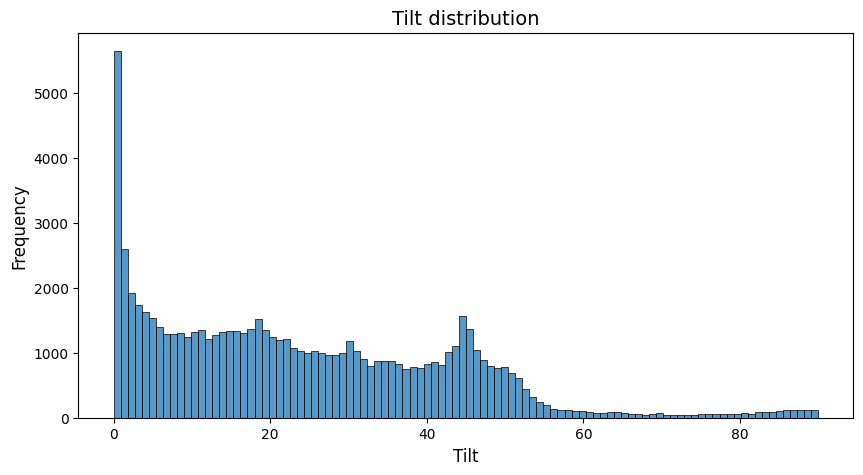

In [274]:
utils.plot_hist(roofs_data_filtered[TILT], 'Tilt distribution', 'Tilt', 'Frequency', bins=100)

In [275]:
print(f"The percentage of steep roofs {roofs_data_filtered[roofs_data_filtered[TILT] > 60].shape[0] / roofs_data_filtered.shape[0] * 100:.2f}%")

The percentage of steep roofs 3.27%


In [276]:
roofs_data_filtered = roofs_data_filtered[roofs_data_filtered[TILT] <= 60]

In [277]:
roofs_data_filtered.describe()

,roof_id,tilt,azimuth,roof_area,azimuth_new
count,72446.000000,72446.000000,72446.000000,72446.000000,72445.000000
mean,39737.570259,22.183004,-5.214876,66.510806,-1.139529
std,22947.389314,16.326522,101.946614,167.283369,104.499842
min,2.000000,0.000000,-180.000000,2.003090,-180.000000
25%,19823.500000,7.453000,-90.000000,13.559419,-91.499547
50%,39758.500000,19.778000,-2.160059,30.782643,-5.163361
75%,59595.500000,35.817500,85.479145,63.025971,87.064327
max,79443.000000,59.997000,180.000000,9387.990723,180.000000


In [278]:
roofs_data_filtered[roofs_data_filtered[AZIMUTH_NEW].isna()]

,etak_id,roof_id,tilt,azimuth,orientation,roof_area,points,azimuth_new,orientation_new
24593,721220,24594,0.0,-90.0,none,16.751953,"[[6471202.41, 662571.64, 2.740000000000002], [...",NaN,none


In [279]:
roofs_data_filtered.loc[24593, AZIMUTH_NEW] = roofs_data_filtered.loc[24593, AZIMUTH]

In [280]:
roofs_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72446 entries, 1 to 79442
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   etak_id          72446 non-null  object 
 1   roof_id          72446 non-null  int64  
 2   tilt             72446 non-null  float64
 3   azimuth          72446 non-null  float64
 4   orientation      72446 non-null  object 
 5   roof_area        72446 non-null  float64
 6   points           72446 non-null  object 
 7   azimuth_new      72446 non-null  float64
 8   orientation_new  72446 non-null  object 
dtypes: float64(4), int64(1), object(4)
memory usage: 7.5+ MB


In [281]:
roofs_number

79443

In [282]:
roofs_data_filtered.shape

(72446, 9)

In [283]:
roofs_data_filtered.groupby([TILT, AZIMUTH_NEW]).size()

tilt    azimuth_new
0.000   -180.000000     106
        -90.000000     1438
         0.000000       107
0.009   -155.796736       1
0.010   -2.501165         1
                       ... 
59.977  -32.752158        1
59.978  -147.462849       1
59.979  -128.576076       1
59.982   79.359380        1
59.997  -50.716834        1
Length: 70793, dtype: int64

In [284]:
roofs_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72446 entries, 1 to 79442
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   etak_id          72446 non-null  object 
 1   roof_id          72446 non-null  int64  
 2   tilt             72446 non-null  float64
 3   azimuth          72446 non-null  float64
 4   orientation      72446 non-null  object 
 5   roof_area        72446 non-null  float64
 6   points           72446 non-null  object 
 7   azimuth_new      72446 non-null  float64
 8   orientation_new  72446 non-null  object 
dtypes: float64(4), int64(1), object(4)
memory usage: 7.5+ MB


In [285]:
roofs_data_filtered[TILT + "_rounded"] = roofs_data_filtered[TILT].round().astype(int)
roofs_data_filtered[AZIMUTH_NEW + "_rounded"] = roofs_data_filtered[AZIMUTH_NEW].round().astype(int)

In [286]:
roofs_data_filtered.groupby([TILT + "_rounded", AZIMUTH_NEW + "_rounded"]).size()

tilt_rounded  azimuth_new_rounded
0             -180                   111
              -179                     5
              -178                     4
              -177                     8
              -176                     8
                                    ... 
60             154                     1
               172                     1
               174                     2
               175                     2
               177                     2
Length: 18570, dtype: int64

In [173]:
roofs_data_filtered.to_csv(ROOFS_DIR.joinpath("roofs_data_cleaned.csv"), index=False)

In [287]:
roofs_data_azimuth_filtered = roofs_data_filtered[(roofs_data_filtered[AZIMUTH_NEW] >= -90) & (roofs_data_filtered[AZIMUTH_NEW] <= 90) | (roofs_data_filtered[ORIENTATION_NEW] == NONE)].copy()

In [288]:
roofs_data_filtered[ORIENTATION_NEW].value_counts()

orientation_new
none     21705
south    12989
north    12810
east     12786
west     12156
Name: count, dtype: int64

In [289]:
roofs_data_azimuth_filtered[ORIENTATION_NEW].value_counts()

orientation_new
none     21705
south    12989
west      6828
east      5840
Name: count, dtype: int64

In [290]:
roofs_data_azimuth_filtered[POINTS] = roofs_data_azimuth_filtered[POINTS].apply(lambda x: ast.literal_eval(x))


In [291]:
roofs_data_azimuth_filtered[POLYGON] = roofs_data_azimuth_filtered.apply(utils.create_polygon, axis=1)


In [292]:
roofs_data_azimuth_filtered = roofs_data_azimuth_filtered[roofs_data_azimuth_filtered[POLYGON].apply(lambda polygon: polygon.is_valid)]

In [293]:
roofs_data_azimuth_filtered.shape[0]

47280

In [294]:
roofs_data_azimuth_filtered.columns

Index(['etak_id', 'roof_id', 'tilt', 'azimuth', 'orientation', 'roof_area',
       'points', 'azimuth_new', 'orientation_new', 'tilt_rounded',
       'azimuth_new_rounded', 'polygon'],
      dtype='object')

In [295]:
roofs_data_filtered_final = roofs_data_azimuth_filtered.groupby([ETAK_ID, ORIENTATION_NEW]).apply(utils.filter_roofs_by_coordnates).reset_index(drop=True)

In [304]:
filtered_roofs_number = roofs_data_filtered_final.shape[0]
filtered_roofs_number

45993

In [297]:
roofs_data_filtered_final.groupby([TILT, AZIMUTH_NEW]).size()

tilt    azimuth_new
0.000   -180.000000     101
        -90.000000     1353
         0.000000       103
0.009   -155.796736       1
0.010   -2.501165         1
                       ... 
59.952   53.387034        1
59.975  -86.054814        1
59.977  -32.752158        1
59.982   79.359380        1
59.997  -50.716834        1
Length: 44435, dtype: int64

In [305]:
print(f"{(1 - (filtered_roofs_number / roofs_number)) * 100:.2f}% of roofs were filtered out")

42.11% of roofs were filtered out


In [308]:
filtered_roofs_area = roofs_data_filtered_final[ROOF_AREA].sum()

In [309]:
print(f"{(1 - (filtered_roofs_area / roofs_area)) * 100:.2f}% of roofs area filtered out")

29.86% of roofs area filtered out


In [299]:
roofs_data_filtered_final.groupby([TILT + "_rounded", AZIMUTH_NEW + "_rounded"]).size()

tilt_rounded  azimuth_new_rounded
0             -180                   105
              -179                     5
              -178                     4
              -177                     8
              -176                     8
                                    ... 
60             52                      1
               53                      1
               78                      1
               79                      1
               84                      1
Length: 11211, dtype: int64

In [300]:
roofs_data_filtered_final.head(1)

,etak_id,roof_id,tilt,azimuth,orientation,roof_area,points,azimuth_new,orientation_new,tilt_rounded,azimuth_new_rounded,polygon
0,333302,60414,46.534,-26.2764,south,51.830155,"[[6481314.09, 652658.48, 5.910000000000004], [...",-63.7236,east,47,-64,"POLYGON ((652658.48 6481314.09, 652661.54 6481..."


In [301]:
roofs_data_filtered_final.drop(columns=[TILT, AZIMUTH, ORIENTATION, POLYGON], inplace=True)
roofs_data_filtered_final.rename(columns={AZIMUTH_NEW + "_rounded": AZIMUTH}, inplace=True)
roofs_data_filtered_final.drop(columns=[AZIMUTH_NEW], inplace=True)
roofs_data_filtered_final.rename(columns={TILT + "_rounded": TILT}, inplace=True)
roofs_data_filtered_final.rename(columns={ORIENTATION_NEW: ORIENTATION}, inplace=True)

In [302]:
roofs_data_filtered_final.head(1)

,etak_id,roof_id,roof_area,points,orientation,tilt,azimuth
0,333302,60414,51.830155,"[[6481314.09, 652658.48, 5.910000000000004], [...",east,47,-64


In [303]:
roofs_data_filtered_final[ETAK_ID].unique().size

16757

In [239]:
roofs_data_filtered_final.to_csv(ROOFS_FILTERED_PATH, index=False)

### Production recalculation and comparison with real data

In [ ]:
await pvgis_requests_processing.main(ROOFS_FILTERED_PATH, TARTU_LAT, TARTU_LON, EFFICIENCY, LOSS)


In [221]:
roofs_estimated_production = pd.read_csv(ROOFS_DIR.joinpath("estimated_production.csv"))

In [222]:
buildings_estimated_production = roofs_estimated_production.groupby(ETAK_ID).agg({
    ANNUAL_KWH_PV_M2: 'mean',
    YY_VARIATION_PV_M2: 'mean',
    MONTHLY_AVERAGE_KWH_PV_M2: 'mean',
    ROOF_AREA: 'sum',
    **{col: 'mean' for col in MONTHS_ABBR_UNITS_PV_M2}
})


In [223]:
buildings_estimated_production.rename(columns={ROOF_AREA: "pv_suitable_area"}, inplace=True)
buildings_estimated_production.reset_index(inplace=True)

In [224]:
buildings_estimated_production.shape

(16757, 17)

In [225]:
buildings_estimated_production.to_csv(BUILDINGS_DIR.joinpath("new_estimated_prod_by_building.csv"), index=False)

In [310]:
real_production = pd.read_csv(DATA_DIR.joinpath("real_monthly_prod.csv"))

In [311]:
suffixes = ["_r", "_e"]
monthly_real_prod_columns = [ETAK_ID, ADDRESS, YEAR] + MONTHS_ABBR_UNITS_PV_M2
monthly_est_prod_columns = [ETAK_ID] + MONTHS_ABBR_UNITS_PV_M2

In [312]:
def merge_dataframes(year, real_production_df, columns_real_prod, columns_estimated_prod):
    production_for_year = real_production_df[real_production_df[YEAR] == year]
    return production_for_year[columns_real_prod].merge(
        buildings_estimated_production[columns_estimated_prod], 
        how="left", 
        on=ETAK_ID, 
        suffixes=suffixes
    )

merged_monthly_production_2022 = merge_dataframes(
    2022,
    real_production,
    monthly_real_prod_columns,
    monthly_est_prod_columns
)


In [313]:
seasons = ["Winter", "Spring", "Summer", "Autumn"]

labels = []
for abbr in [MONTHS_ABBR_UNITS_PV_M2[-1]] + MONTHS_ABBR_UNITS_PV_M2[0:-1]:
    labels.append(abbr + suffixes[0])
    labels.append(abbr + suffixes[1])


In [314]:
def construct_comparison_csv():
    for i in range(len(seasons)):
        with open(f"{DATA_DIR.joinpath('output/prod_comparison_new.csv')}", 'a') as file:
            file.write(f"\n{seasons[i]} 2022\n")
        columns = [ETAK_ID, ADDRESS, YEAR] + labels[i*6:(i+1)*6]
        merged_monthly_production_2022[columns].to_csv(
            DATA_DIR.joinpath('output/prod_comparison_new.csv'),
            mode='a',
            header=True,
            index=False,
            na_rep="NaN"
        )
            
construct_comparison_csv()


In [81]:
merged_monthly_production_nan_filled = merged_monthly_production_2022[labels].fillna(merged_monthly_production_2022[labels].mean())

In [82]:
for i in range(len(seasons)):
    columns = labels[i*6:(i+1)*6]
    seasonal_real_prod = merged_monthly_production_nan_filled[columns[0]] + merged_monthly_production_nan_filled[columns[2]] + merged_monthly_production_nan_filled[columns[4]]
    seasonal_estimated_prod = merged_monthly_production_nan_filled[columns[1]] + merged_monthly_production_nan_filled[columns[3]] + merged_monthly_production_nan_filled[columns[5]]
    try:
        print(f"MAPE for {seasons[i]}: {mean_absolute_percentage_error(seasonal_real_prod, seasonal_estimated_prod) * 100:.2f}%")
    except Exception as e:
        print(f"Cannot calculate MAPE for season {seasons[i]} due to the error {e}") 

Cannot calculate MAPE for season Winter due to the error Input contains NaN.
MAPE for Spring: 12.37%
MAPE for Summer: 13.01%
MAPE for Autumn: 18.74%


In [83]:
winter_real = merged_monthly_production_nan_filled[labels[2]] + merged_monthly_production_nan_filled[labels[4]]
winter_estimated = merged_monthly_production_nan_filled[labels[3]] + merged_monthly_production_nan_filled[labels[5]]
print(f"MAPE for Winter: {mean_absolute_percentage_error(winter_real, winter_estimated) * 100:.2f}%")


MAPE for Winter: 118.05%


In [315]:
real_annual_energy_production = pd.read_csv(ANNUAL_REAL_PROD)
real_annual_energy_production[ANNUAL_KWH_PV_M2] = real_annual_energy_production[ANNUAL_KWH]\
    .divide(real_annual_energy_production[PV_AREA_M2], axis=0)

annual_real_prod_columns = [ETAK_ID, ADDRESS, YEAR, ANNUAL_KWH_PV_M2]
annual_est_prod_columns = [ETAK_ID, YY_VARIATION_PV_M2, ANNUAL_KWH_PV_M2]

annual_pv_m2_merged_2022 = merge_dataframes(
    2022,
    real_annual_energy_production,
    annual_real_prod_columns, 
    annual_est_prod_columns
)


In [316]:
annual_pv_m2_merged_2022

,etak_id,address,year,annual_kwh/pv_m2_r,y-y_variation/pv_m2,annual_kwh/pv_m2_e
0,719155,Tiigi 19,2022,169.259269,7.650,155.265
1,716647,Tähe 2,2022,166.303082,8.215,160.530
2,720043,Aleksandri 3,2022,158.044050,6.460,147.650
3,715116,Turu 9,2022,160.651809,6.120,143.950
4,713413,Turu 3,2022,149.787234,8.740,164.100
5,720467,Pepleri 3,2022,142.088628,6.010,142.870
6,720239,Pepleri 12,2022,155.800780,6.050,143.230
7,720448,J.Kuperjanovi 2,2022,149.628635,7.160,154.670
8,719935,Lutsu 16,2022,107.959835,7.020,153.450
9,720853,Tiigi 21,2022,144.849215,6.110,143.410


In [90]:
((annual_pv_m2_merged_2022[YY_VARIATION_PV_M2] / annual_pv_m2_merged_2022[ANNUAL_KWH_PV_M2 + "_e"]) * 100).mean()


4.531199889909574

In [86]:
mean_squared_error(annual_pv_m2_merged_2022[ANNUAL_KWH_PV_M2 + "_r"],
                   annual_pv_m2_merged_2022[ANNUAL_KWH_PV_M2 + "_e"], squared=False)

20.645837114344772

In [87]:
mean_absolute_percentage_error(annual_pv_m2_merged_2022[ANNUAL_KWH_PV_M2 + "_r"], annual_pv_m2_merged_2022[ANNUAL_KWH_PV_M2 + "_e"])

0.11825276702252042

In [317]:
annual_pv_m2_merged_2022.to_csv(DATA_DIR.joinpath("output/new_annual_prod_comparison_2022.csv"), index=False)